In [42]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

If you look at the "GeneAnno" plot (ie genomic region annotations), "genic enhancers" occur more frequently in gene bodies, and occur in exons, while "enhancers" (state 7) occur less frequently in gene bodies and almost never in exons. Both seem to occur in introns with equal frequency. If you dig into the raw data, you can also see that the "genic enhancers" occur at TSS about twice as frequently. Also, the "genic enhancers" occur about 26 times less frequently genome-wide.
http://egg2.wustl.edu/roadmap/data/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final/annotationEnrichment_RoadmapEp_coreMarks_15State.png
http://egg2.wustl.edu/roadmap/data/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final/E003_15_coreMarks_geneAnno_overlap.txt
It's important to note that these are probabilistic categories based solely on the histone marks -- there are probably some promoters/TSS mixed in with the regions annotated as genic enhancers. Conversely, many of the genic enhancers may be located intergenically. Lastly, there is no guarantee that any of the regions annotated as enhancers actually function as such. If they do function as enhancers, then they must, by necessity, be brought into proximity to promoters via enhancer-promoter looping. This mechanism functions regardless of whether they are genic or intergenic.

# running ChromHMM

In [33]:
f1 = '/projects/da_workspace/software/ChromHMM/Cervical_new/libs.txt.sorted'
df1 = pd.read_csv(f1, sep='\t', header=None, index_col=0)
df1.head(2)

,1,2
0,,
A84610,H3K4me1,HTMCP-03-06-02001
A84611,H3K4me3,HTMCP-03-06-02001


In [34]:
# f2 = '/projects/da_workspace/software/ChromHMM/Cervical_new/peak_files.txt.sorted'
f2 = '/projects/da_workspace/software/ChromHMM/Cervical_new/peak_files_after_topup.txt'
df2 = pd.read_csv(f2, sep='\t', header=None, index_col=0)
df2.head(2)

,1
0,
A84610,/projects/chipseq/macs/A84610/75nt/hg19a/bwa-0...
A84612,/projects/chipseq/macs/A84612/75nt/hg19a/bwa-0...


In [35]:
df3 = pd.merge(df1, df2, left_index=True, right_index=True)
df3.shape
df3.columns = ['mark', 'patient', 'peak_file']
df3 = df3[['patient', 'mark', 'peak_file']]
df3.head(2)

(210, 3)

,patient,mark,peak_file
0,,,
A84610,HTMCP-03-06-02001,H3K4me1,/projects/chipseq/macs/A84610/75nt/hg19a/bwa-0...
A84611,HTMCP-03-06-02001,H3K4me3,/projects/chipseq/macs/A84611/75nt/hg19a/bwa-0...


In [36]:
df3['pfile'] = df3.peak_file.apply(lambda x: x.split('/')[-1])

In [37]:
df3.drop('peak_file', axis=1, inplace=True)

In [38]:
df3.head()

,patient,mark,pfile
0,,,
A84610,HTMCP-03-06-02001,H3K4me1,A84610_H3K4me1_peaks.broadPeak
A84611,HTMCP-03-06-02001,H3K4me3,A84611_H3K4me3_peaks.narrowPeak
A84612,HTMCP-03-06-02001,H3K9me3,A84612_H3K9me3_peaks.broadPeak
A84613,HTMCP-03-06-02001,H3K27me3,A84613_H3K27me3_peaks.broadPeak
A84614,HTMCP-03-06-02001,H3K36me3,A84614_H3K36me3_peaks.broadPeak


In [39]:
of1 = '/projects/da_workspace/software/ChromHMM/Cervical_new/cellmarkfiletable.txt'
df3.to_csv(of1, sep='\t', index=False, header=False)

In [41]:
%%bash
ssh gphost06
cd /projects/da_workspace/software/ChromHMM
# make chromhmm input file cellmarkerfiletable.txt
# create symlink to the MCS2 broadPeaks and narrowPeaks files

/gsc/software/linux-x86_64-centos6/jdk1.8.0_102/bin/java -mx1600M -jar ChromHMM.jar BinarizeBed -b 200 -peaks CHROMSIZES/hg19.txt /projects/da_workspace/software/ChromHMM/Cervical_new/peak_bed_files/ /projects/da_workspace/software/ChromHMM/Cervical_new/cellmarkfiletable.txt /projects/da_workspace/software/ChromHMM/Cervical_new/binary/

# add chr suffix to binary files
cd /projects/da_workspace/software/ChromHMM/Cervical_new/binary/
for f in *_binary.txt;do awk '/^HTMCP/{$2="chr"$2} 1' $f |sed 's/ /\t/g'> $f.chr_suffix;done 
rm *_binary.txt

# run chromHMM, need to run on gphost because of memory requirement
# /gsc/software/linux-x86_64-centos6/jdk1.8.0_102/bin/java -Xmx50g -jar ChromHMM.jar LearnModel -b 200 -p 0 ./Cervical_new/binary/ ./Cervical_new/18_states 18 hg19

# or run for multiple states models
cd /projects/da_workspace/software/ChromHMM
for f in 15 16 17 18 19 20 21;do mkdir ./Cervical_new/$f"_states"; /gsc/software/linux-x86_64-centos6/jdk1.8.0_102/bin/java -Xmx50g -jar ChromHMM.jar LearnModel -b 200 -p 0 ./Cervical_new/binary/ ./Cervical_new/$f"_states" $f hg19;done
for f in 22 23 24;do /gsc/software/linux-x86_64-centos6/jdk1.8.0_102/bin/java -Xmx100g -jar ChromHMM.jar LearnModel -b 200 -p 0 ./Cervical_new/binary/ ./Cervical_new/$f"_states" $f hg19;done

Process is interrupted.


# process segment file for clustering chromHMM results

In [2]:
# # make 20bp bins for the whole genome, only need to run once
# f1 = '~/projects/resource/chrominfo.txt'
# df1 = pd.read_csv(f1, sep='\t', usecols=['#chrom', 'size']).head(24)
# df1.head()

# df1['chr'] = (df1['#chrom'].str.replace('chr', '')).replace('X', 23).replace('Y', 24).astype(int)

# df1 = df1.sort_values('chr')

# df1.shape

# # binning the whole genome
# lst = []
# for ix, row in df1.iterrows():
#     c = row['chr']
#     s = row['size']
#     bin_size = 200
#     i = 0 
#     while i < s:      
#         lst.append([c, i, i + 199])
#         i+=200
# pd.DataFrame(lst).to_csv('~/projects/resource/chromsome_bins_200bp.txt', index=False, header=False, sep='\t')

In [43]:
%%bash
# need to reprocessing the chromHMM run after the top up, waiting for alessia to determine which state is most informative
cd /projects/da_workspace/software/ChromHMM/Cervical_new/22_states
while read i;do sed 's/chr//g' $i|sed 's/X/23/g'|sed 's/Y/24/g'|sort -k1n -k2n -k3n >$i.sorted;done<segments_bed_files.txt
#now intersect chromosome bins and chromHMM segment bed files
bedtools="/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools"
while read i;do $bedtools intersect -a ~/projects/resource/chromsome_bins_200bp.txt -b $i.sorted -wa -wb > $i.sorted.intersected;done < segments_bed_files.txt

In [47]:
f = '/projects/da_workspace/software/ChromHMM/Cervical_new/22_states/segments_sorted_intersected_files.txt'
df11 = pd.read_csv(f, header=None)
df11.columns = ['files']
df11.head(2)

,files
0,HTMCP-03-06-02001_22_segments.bed.sorted.inter...
1,HTMCP-03-06-02006_22_segments.bed.sorted.inter...


In [54]:
# f = '/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_18/merged_chromhmm_states.txt'
f = '/projects/da_workspace/software/ChromHMM/Cervical_new/22_states/merged_chromatin_states.txt'
df = pd.read_csv(f, sep='\t')
df.head()
df.shape

,chr,start,end,HTMCP-03-06-02001,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02040,...,HTMCP-03-06-02205,HTMCP-03-06-02210,HTMCP-03-06-02214,HTMCP-03-06-02260,HTMCP-03-06-02266,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332,Unnamed: 38
0,1,0,199,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,NaN
1,1,200,399,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,NaN
2,1,400,599,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,NaN
3,1,600,799,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,NaN
4,1,800,999,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,NaN


(15478375, 39)

In [55]:
df = df.drop('Unnamed: 38', axis=1)

df = df.set_index(['chr', 'start', 'end'])

df.head(2)

df_filtered = df[df.apply(lambda x: x.nunique()>1, axis=1)]

df_filtered.shape

HTMCP-03-06-02001  HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr start end                                                            
1   0     199                 10                 10                 10   
    200   399                 10                 10                 10   

               HTMCP-03-06-02012  HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr start end                                                            
1   0     199                 10                 10                 10   
    200   399                 10                 10                 10   

               HTMCP-03-06-02040  HTMCP-03-06-02042  HTMCP-03-06-02054  \
chr start end                                                            
1   0     199                 10                 10                 10   
    200   399                 10                 10                 10   

               HTMCP-03-06-02058        ...          HTMCP-03-06-02203  \
chr start end                           ...                              
1   0     199                 10        ...                         10   
    200   399                 10        ...                         10   

               HTMCP-03-06-02205  HTMCP-03-06-02210  HTMCP-03-06-02214  \
chr start end                                                            
1   0     199                 10                 10                 10   
    200   399                 10                 10                 10   

               HTMCP-03-06-02260  HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr start end                                                            
1   0     199                 10                 10                 10   
    200   399                 10                 10                 10   

               HTMCP-03-06-02320  HTMCP-03-06-02330  HTMCP-03-06-02332  
chr start end                                                           
1   0     199                 10                 10                 10  
    200   399                 10                 10                 10  

[2 rows x 35 columns]

(13327367, 35)

# clustering

In [56]:
f = '/projects/da_workspace/software/ChromHMM/Cervical_new/22_states/merged_chromhmm_differential_states.binary'
# df_filtered.reset_index().to_feather(f)
df_filtered = pd.read_feather(f).set_index(['chr', 'start', 'end'])
df_filtered.head()

HTMCP-03-06-02001  HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 15                 10                 10   
    10200 10399                 15                 10                 10   
    10400 10599                 15                 10                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02012  HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 15                 10                 10   
    10200 10399                 15                 10                 10   
    10400 10599                 15                 10                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02040  HTMCP-03-06-02042  HTMCP-03-06-02054  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 10                 15                 15   
    10200 10399                 10                 15                 15   
    10400 10599                 10                 15                 15   
    10600 10799                 10                 10                 15   

                 HTMCP-03-06-02058        ...          HTMCP-03-06-02203  \
chr start end                             ...                              
1   9800  9999                  10        ...                         10   
    10000 10199                 10        ...                         10   
    10200 10399                 10        ...                         10   
    10400 10599                 10        ...                         10   
    10600 10799                 10        ...                         10   

                 HTMCP-03-06-02205  HTMCP-03-06-02210  HTMCP-03-06-02214  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 21                 15                 10   
    10200 10399                 21                 15                 10   
    10400 10599                 10                 15                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02260  HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 10                 10                 10   
    10200 10399                 10                 10                 10   
    10400 10599                 10                 10                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02320  HTMCP-03-06-02330  HTMCP-03-06-02332  
chr start end                                                             
1   9800  9999                  10                 10                 10  
    10000 10199                 10                 10                 15  
    10200 10399                 10                 10                 15  
    10400 10599                 10                 10                 15  
    10600 10799                 10                 10                 10  

[5 rows x 35 columns]

In [57]:
# df_filtered.columns = ['HTMCP-03-06-'+i for i in df_filtered.columns.tolist()]

# df_filtered.head()

In [58]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'

In [59]:
nt = '{}numeric_track.txt'.format(wkdir)
ntdf = pd.read_csv(nt)
ntdf.head(2)

,patient,log_strelka_mutations
0,HTMCP-03-06-02007,6.47104
1,HTMCP-03-06-02026,6.09768


In [60]:
cf = '/projects/trans_scratch/validations/workspace/szong/Cervical/clinic_data_extracted.txt'
cfdf = pd.read_csv(cf, sep='\t')
cfdf.head(2)

,bcr_patient_barcode,age_at_diagnosis,tumor_grade,ajcc_tumor_clinical_ct,clinical_stage,cd4_counts_at_diagnosis,hiv_rna_load_at_diagnosis,birth_days_to,menopause_status,height_cm_at_diagnosis,...,ecog_score,nadir_cd4_counts,cd4_counts_at_diagnosis.1,hiv_rna_load_at_diagnosis.1,histologic_diagnosis,haart_therapy_prior_to_dx,haart_therapy_at_dx,keratinization_squamous_cell,days_to_hiv_diagnosis,patient_id
0,HTMCP-03-06-02001,56.0,G2,T2b,Stage IIB,337.0,34.0,NaN,Post (prior bilateral ovariectomy OR >12 mo si...,158.0,...,1,NaN,337.0,34.0,Squamous Cell Carcinoma; Non-Keratinizing,YES,YES,Non-keratinizing squamous cell carcinoma,NaN,2001
1,HTMCP-03-06-02002,62.0,G3,T1b1,Stage IB1,NaN,NaN,-22934.0,Post (prior bilateral ovariectomy OR >12 mo si...,159.0,...,0,NaN,NaN,NaN,Squamous Cell Carcinoma; Non-Keratinizing,NaN,NaN,Non-keratinizing squamous cell carcinoma,NaN,2002


In [61]:
cfdf = cfdf.fillna('unknown')

In [62]:
cfdf.head(2)

,bcr_patient_barcode,age_at_diagnosis,tumor_grade,ajcc_tumor_clinical_ct,clinical_stage,cd4_counts_at_diagnosis,hiv_rna_load_at_diagnosis,birth_days_to,menopause_status,height_cm_at_diagnosis,...,ecog_score,nadir_cd4_counts,cd4_counts_at_diagnosis.1,hiv_rna_load_at_diagnosis.1,histologic_diagnosis,haart_therapy_prior_to_dx,haart_therapy_at_dx,keratinization_squamous_cell,days_to_hiv_diagnosis,patient_id
0,HTMCP-03-06-02001,56,G2,T2b,Stage IIB,337,34,unknown,Post (prior bilateral ovariectomy OR >12 mo si...,158.0,...,1,unknown,337,34,Squamous Cell Carcinoma; Non-Keratinizing,YES,YES,Non-keratinizing squamous cell carcinoma,unknown,2001
1,HTMCP-03-06-02002,62,G3,T1b1,Stage IB1,unknown,unknown,-22934,Post (prior bilateral ovariectomy OR >12 mo si...,159.0,...,0,unknown,unknown,unknown,Squamous Cell Carcinoma; Non-Keratinizing,unknown,unknown,Non-keratinizing squamous cell carcinoma,unknown,2002


In [63]:
cfdf.bcr_patient_barcode.nunique()

137

In [64]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'
ct = '{}category_track.txt'.format(wkdir)
ctdf = pd.read_csv(ct)
ctdf.head(2)

,patient,HIV_status,Putative_histology,clinic_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Adenosquamous,Negative,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


In [102]:
patients_sorted = ctdf.sort_values('HIV_status')['patient']


In [65]:
ctdf.patient.nunique()

35

In [66]:
dfclmg = pd.merge(ctdf, cfdf, right_on='bcr_patient_barcode', left_on='patient', how='left')

In [67]:
dfclmg.shape

(35, 57)

In [68]:
of = '/projects/da_workspace/DA-167_Cervical_epi_clustering/clinic_covariate.txt'
dfclmg.to_csv(of, index=False, sep='\t')

In [69]:
def map_features_to_colors(df_track, map_dict1, clrs):
#     clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
#     map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    map_dict2 = {}
    for n, k in enumerate(map_dict1.keys()):
        map_dict2[k] = clrs[n]
    assert list(map_dict2.values()) == clrs
    ndf_track = df_track.apply(lambda x: x.map(map_dict1)).fillna(0).T
#     legends = sorted(map_dict1, key=map_dict1.get, reverse=False)
    return (ndf_track, map_dict2)

In [70]:
def plot_cluster_heatmap(numeric_track, category_track, dfm, dfaa, mark, map_dict2, of): # df= tracks, dfm = histone mark signal df
#     df = ncategory_track.copy() # track df
    # dfm: histone mark signal df

    fig = plt.figure(figsize=(10, 16), facecolor='white', frameon=False)
    gs = gridspec.GridSpec(1, 2, width_ratios=[17,1], 
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )

    bounds = np.arange(0.1, len(map_dict1)/10.0 + 0.2 , 0.1).tolist()
    print('bounds: {}'.format(bounds))
    assert len(bounds) == len(map_dict1) + 1
    # make a color map of fixed colors
    cmap = colors.ListedColormap(clrs)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    nrow = len(category_track.index)
    ncol = len(category_track.columns)
    print('category track shape: rows={0}, cols={1}'.format(nrow, ncol))

    # left panel 3x1 for n_track, c_trak, and dendrogram
    gs01 = gridspec.GridSpecFromSubplotSpec(3, 1,  height_ratios=[.5, 14, 4], subplot_spec=gs[0],  hspace=0.0)
    
     # add dendrogram
    ax1_3 = fig.add_subplot(gs01[2])
    ax1_3.set_title("")
#     ax1_3 = fig.add_subplot(gs[4], facecolor='white')
    matrix = dfm.values.T
    dist = 'jaccard'
    link = 'complete'
    
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
    den_labels = aa['ivl']
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
    c_track = category_track[den_labels]

#     c_track = pd.merge(adf, category_track.T, left_on='patient', right_index=True)#.drop(0, axis=1)
#     c_track = c_track.set_index('patient')
#     c_track = c_track.T
#     plt.suptitle('unsupervised_clustering_{}'.format(mark), fontsize=14)  
    plt.suptitle('total states= {0}, state{1}, pdist={2}, linkage={3}'.format(states, i, dist, link))
#     print(den_labels)

    
    # plot category track
    ax1_2 = fig.add_subplot(gs01[1], facecolor='white')
#     ax1_2.set_title("")
#     print(c_track)
    img = ax1_2.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                        cmap=cmap, norm=norm)
    _ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

    _ = ax1_2.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_2.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_2.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_2.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_2.spines['right'].set_visible(True)
    ax1_2.spines['top'].set_visible(True)
    ax1_2.set_xticklabels('')
#     print(c_track.columns)
    

    # plot numeric track
    ax1_1 = fig.add_subplot(gs01[0], facecolor='white')
#     ax1_1.set_title("")
    numeric_track = numeric_track.set_index('patient').astype(float)
    n_track = pd.merge(adf, numeric_track, left_on='patient', right_index=True)#.drop(0, axis=1)
    n_track = n_track.set_index('patient')
    n_track = n_track.T
    nrow = len(n_track.index)
    ncol = len(n_track.columns)
    print('numeric track shape: rows={0}, cols={1}'.format(nrow, ncol))
    img1_1 = ax1_1.imshow(n_track.values, interpolation='none', origin='upper', aspect='auto', cmap='Reds')
    _ = plt.yticks(np.arange(0, nrow, 1), n_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), n_track.columns, fontsize=8, rotation=90)

    _ = ax1_1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_1.spines['right'].set_visible(True)
    ax1_1.spines['top'].set_visible(True)
    ax1_1.set_xticklabels('')
#     print(n_track.columns)

    

    # right panel 2x1 for lengends, colorbar and rectangles
    gs02 = gridspec.GridSpecFromSubplotSpec(2, 1,  height_ratios=[1, 1], subplot_spec=gs[1])
    
    # color bar for numeric_track 
    ax2_1 = fig.add_subplot(gs02[0], facecolor='white')
    ax2_1.set_title("mutations_log10")        
    _ = plt.colorbar(img1_1, cax=ax2_1, orientation= 'vertical', label='')#, aspect=40) 

    
    # add retangle legend for category track
    ax2_2 = fig.add_subplot(gs02[1], facecolor='white')
#     ax2_2.set_title("rectangles")
        
    # plot category track legend
    k = 1
    for key in map_dict2:
        if key !=0: # don't plot key=0 which means no mutation
            clr = map_dict2[key]
            rect = patches.Rectangle((0,k/7), 0.3, 0.1, linewidth=0.01,edgecolor=clr,facecolor=clr)
            _ = ax2_2.text(0.35, k/7+.07, key, ha='left', va='center', fontsize=8)
            _ = ax2_2.add_patch(rect)
        k+=1
    ax2_2.get_xaxis().set_ticks([])
    ax2_2.get_yaxis().set_ticks([])
    ax2_2.set_title('')

    assert den_labels == c_track.columns.tolist()
    assert den_labels == n_track.columns.tolist()
    plt.tight_layout()    
    %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
    return den_labels

In [202]:
# number of intervals in the state matrix: state 1 to 18
# (1102283, 35)
# (722258, 35)
# (1235504, 35)
# (1984906, 35)
# (2368741, 35)
# (400702, 35)
# (957355, 35)
# (600460, 35)
# (1739308, 35)
# (3559887, 35)
# (736242, 35)
# (7276338, 35)
# (11355333, 35)
# (1490690, 35)
# (4328709, 35)
# (646583, 35)
# (2547691, 35)
# (5328716, 35)


what are regions which can definitely distinguish hiv + and -?

In [ ]:
df_filtered = df_filtered[patients_sorted]

In [115]:
df_filtered.head(2)

HTMCP-03-06-02007  HTMCP-03-06-02182  HTMCP-03-06-02006  \
chr start end                                                              
1   9800  9999                  10                 15                 10   
    10000 10199                 10                 15                 10   

                 HTMCP-03-06-02040  HTMCP-03-06-02075  HTMCP-03-06-02266  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 10                 10                 10   

                 HTMCP-03-06-02180  HTMCP-03-06-02203  HTMCP-03-06-02210  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 10                 10                 15   

                 HTMCP-03-06-02012        ...          HTMCP-03-06-02058  \
chr start end                             ...                              
1   9800  9999                  10        ...                         10   
    10000 10199                 15        ...                         10   

                 HTMCP-03-06-02330  HTMCP-03-06-02020  HTMCP-03-06-02320  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 10                 10                 10   

                 HTMCP-03-06-02054  HTMCP-03-06-02001  HTMCP-03-06-02260  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 15                 15                 10   

                 HTMCP-03-06-02109  HTMCP-03-06-02128  HTMCP-03-06-02076  
chr start end                                                             
1   9800  9999                  10                 15                 10  
    10000 10199                 21                 15                 14  

[2 rows x 35 columns]

In [124]:
# df col ordered by hiv status , negative>positive
df_filtered['num_states'] = df_filtered.apply(lambda x: x.nunique(), axis=1)
df_filtered['pos_num_states'] = df_filtered.iloc[:, :17].apply(lambda x: x.nunique(), axis=1)
df_filtered['neg_num_states'] = df_filtered.iloc[:, 17:35].apply(lambda x: x.nunique(), axis=1)


/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

(13327367, 35)
bounds: [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6]
category track shape: rows=28, cols=35
numeric track shape: rows=1, cols=35


/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


CPU times: user 1min 59s, sys: 6.45 s, total: 2min 6s
Wall time: 4.32 s


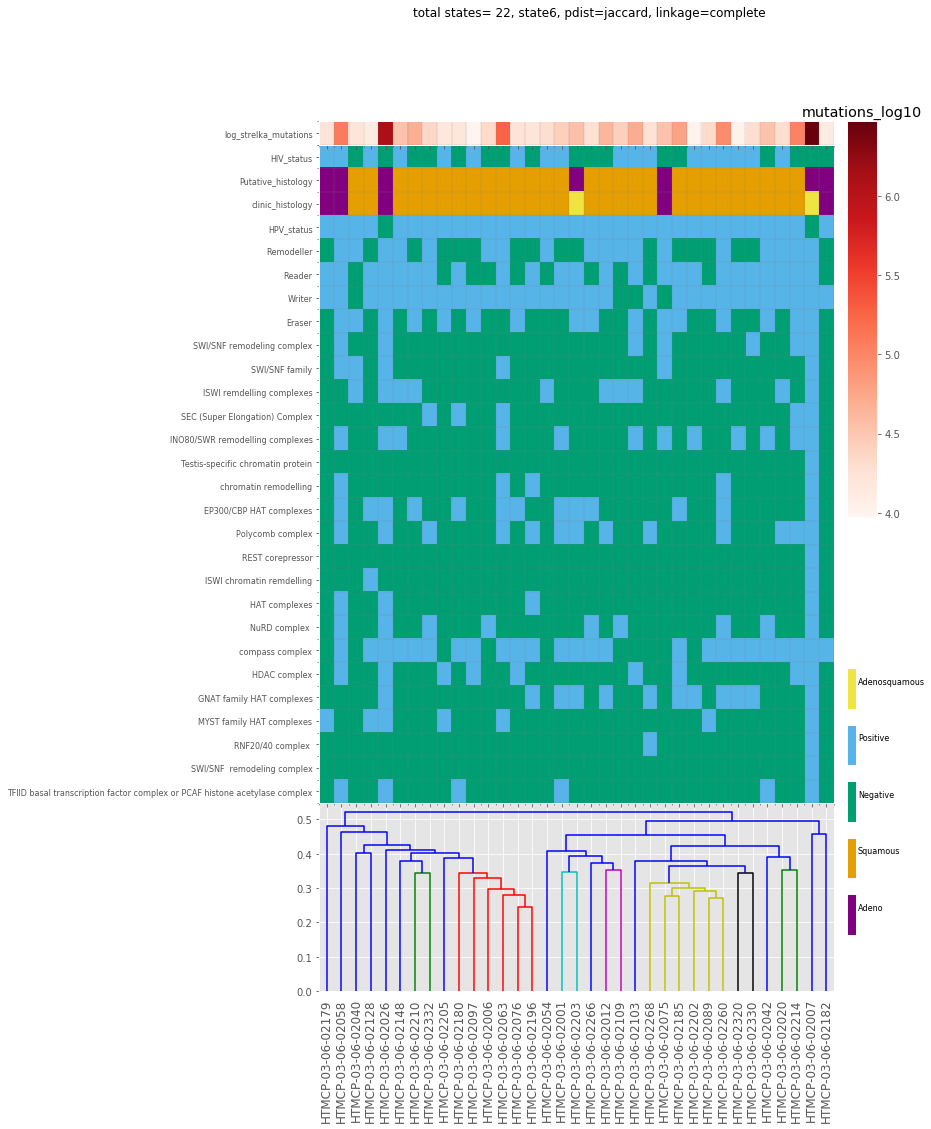

In [94]:
# state 17 represent k36me3 
# dist = 'jaccard'
dist = 'hamming'
link = 'complete'
# link = 'ward'
cat_track = ctdf.set_index('patient')
clrs = ["purple", "#E69F00","#009E73","#56B4E9","#F0E442"]#"#377EB8"]#,"#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45, 'Adenosquamous':0.55}
ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
states = 22
for i in range(1, 1+1):    
#     test out activate promoters
    i = 6
#     df17 = (df_filtered[(df_filtered == i).sum(axis=1) != 0] == i)
    df17 = df_filtered
    
#     pick most variable segments
#     df17['sum'] = df17.sum(axis=1)
#     df17 = df17[(df17['sum'] >10) &(df17['sum']<24)].drop('sum', axis=1)
    print(df17.shape)
    wkdir = '/projects/da_workspace/software/ChromHMM/Cervical_new/22_states'
    matrix = df17.values.T
    
    mark = 'state{}'.format(i)
    of = '/projects/da_workspace/software/ChromHMM/Cervical_new/22_states/unsupervised_clustering_chromhmm_state_{}.png'.format(i)
    den_labels = plot_cluster_heatmap(ntdf, ncategory_track, df17, df17, mark, map_dict2, of)
#     ax.set_title('total states= {0}, state{1}, pdist={2}, linkage={3}'.format(states, i, dist, link))
    plt.show()
    plt.close()

In [93]:
df_filtered.head()

HTMCP-03-06-02001  HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 15                 10                 10   
    10200 10399                 15                 10                 10   
    10400 10599                 15                 10                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02012  HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 15                 10                 10   
    10200 10399                 15                 10                 10   
    10400 10599                 15                 10                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02040  HTMCP-03-06-02042  HTMCP-03-06-02054  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 10                 15                 15   
    10200 10399                 10                 15                 15   
    10400 10599                 10                 15                 15   
    10600 10799                 10                 10                 15   

                 HTMCP-03-06-02058        ...          HTMCP-03-06-02203  \
chr start end                             ...                              
1   9800  9999                  10        ...                         10   
    10000 10199                 10        ...                         10   
    10200 10399                 10        ...                         10   
    10400 10599                 10        ...                         10   
    10600 10799                 10        ...                         10   

                 HTMCP-03-06-02205  HTMCP-03-06-02210  HTMCP-03-06-02214  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 21                 15                 10   
    10200 10399                 21                 15                 10   
    10400 10599                 10                 15                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02260  HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr start end                                                              
1   9800  9999                  10                 10                 10   
    10000 10199                 10                 10                 10   
    10200 10399                 10                 10                 10   
    10400 10599                 10                 10                 10   
    10600 10799                 10                 10                 10   

                 HTMCP-03-06-02320  HTMCP-03-06-02330  HTMCP-03-06-02332  
chr start end                                                             
1   9800  9999                  10                 10                 10  
    10000 10199                 10                 10                 15  
    10200 10399                 10                 10                 15  
    10400 10599                 10                 10                 15  
    10600 10799                 10                 10                 10  

[5 rows x 35 columns]

In [355]:
cfdf.head(2)

,bcr_patient_barcode,age_at_diagnosis,tumor_grade,ajcc_tumor_clinical_ct,clinical_stage,cd4_counts_at_diagnosis,hiv_rna_load_at_diagnosis,birth_days_to,menopause_status,height_cm_at_diagnosis,...,ecog_score,nadir_cd4_counts,cd4_counts_at_diagnosis.1,hiv_rna_load_at_diagnosis.1,histologic_diagnosis,haart_therapy_prior_to_dx,haart_therapy_at_dx,keratinization_squamous_cell,days_to_hiv_diagnosis,patient_id
0,HTMCP-03-06-02001,56.0,G2,T2b,Stage IIB,337.0,34.0,NaN,Post (prior bilateral ovariectomy OR >12 mo si...,158.0,...,1,NaN,337.0,34.0,Squamous Cell Carcinoma; Non-Keratinizing,YES,YES,Non-keratinizing squamous cell carcinoma,NaN,2001
1,HTMCP-03-06-02002,62.0,G3,T1b1,Stage IB1,NaN,NaN,-22934.0,Post (prior bilateral ovariectomy OR >12 mo si...,159.0,...,0,NaN,NaN,NaN,Squamous Cell Carcinoma; Non-Keratinizing,NaN,NaN,Non-keratinizing squamous cell carcinoma,NaN,2002


In [366]:
fakedf = pd.DataFrame(index=den_labels)

In [382]:
cvdf = pd.merge(fakedf, cfdf, left_index=True, right_on='bcr_patient_barcode', how='left')

In [373]:
cvdf.head(2)

,bcr_patient_barcode,age_at_diagnosis,tumor_grade,ajcc_tumor_clinical_ct,clinical_stage,cd4_counts_at_diagnosis,hiv_rna_load_at_diagnosis,birth_days_to,menopause_status,height_cm_at_diagnosis,...,ecog_score,nadir_cd4_counts,cd4_counts_at_diagnosis.1,hiv_rna_load_at_diagnosis.1,histologic_diagnosis,haart_therapy_prior_to_dx,haart_therapy_at_dx,keratinization_squamous_cell,days_to_hiv_diagnosis,patient_id
33,HTMCP-03-06-02076,32.0,G3,T1b2,Stage IB2,480.0,34.0,-11983.0,Pre (<6 months since LMP AND no prior bilatera...,157.0,...,1,NaN,480.0,34.0,Squamous Cell Carcinoma; Non-Keratinizing,YES,YES,Non-keratinizing squamous cell carcinoma,NaN,2076.0
85,HTMCP-03-06-02182,57.0,G3,T2b,Stage IIB,NaN,NaN,NaN,Post (prior bilateral ovariectomy OR >12 mo si...,154.6,...,1,NaN,NaN,NaN,Adenosquamous,NaN,NaN,NaN,NaN,2182.0


In [416]:
cvdf

bcr_patient_barcode,HTMCP-03-06-02076,HTMCP-03-06-02182,HTMCP-03-06-02058,HTMCP-03-06-02001,HTMCP-03-06-02128,HTMCP-03-06-02040,HTMCP-03-06-02210,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02179,...,HTMCP-03-06-02268,HTMCP-03-06-02332,HTMCP-03-06-02054,HTMCP-03-06-02196,HTMCP-03-06-02006,HTMCP-03-06-02109,HTMCP-03-06-02012,HTMCP-03-06-02063,HTMCP-03-06-02203,HTMCP-03-06-02266
age_at_diagnosis,32,57,33,56,46,65,53,65,70,38,...,29,NaN,45,37,34,38,54,62,65,NaN
tumor_grade,G3,G3,G2,G2,G2,G2,G2,G3,G3,G3,...,G2,NaN,G2,G3,G3,G2,G2,G2,G2,NaN
ajcc_tumor_clinical_ct,T1b2,T2b,T2b,T2b,T2a1,T2b,T2b,T3b,T2b,T2b,...,T3b,NaN,T2b,T2a,T2b,T2b,T3b,T2b,T2b,NaN
clinical_stage,Stage IB2,Stage IIB,Stage IIB,Stage IIB,Stage IIA1,Stage IIB,Stage IIB,Stage IIIB,Stage IIB,Stage IIB,...,Stage IIIB,NaN,Stage IIB,Stage IIA,Stage IIB,Stage IIB,Stage IIIB,Stage IIB,Stage IIB,NaN
cd4_counts_at_diagnosis,480,NaN,352,337,480,NaN,NaN,NaN,NaN,427,...,779,NaN,343,NaN,NaN,624,NaN,NaN,NaN,NaN
hiv_rna_load_at_diagnosis,34,NaN,34,34,110,NaN,NaN,NaN,NaN,0,...,0,NaN,34,NaN,NaN,439,NaN,NaN,NaN,NaN
birth_days_to,-11983,NaN,-12229,NaN,-17050,-23795,NaN,NaN,NaN,NaN,...,-10732,NaN,NaN,-13572,NaN,NaN,-19742,NaN,-23873,NaN
menopause_status,Pre (<6 months since LMP AND no prior bilatera...,Post (prior bilateral ovariectomy OR >12 mo si...,Pre (<6 months since LMP AND no prior bilatera...,Post (prior bilateral ovariectomy OR >12 mo si...,Post (prior bilateral ovariectomy OR >12 mo si...,Post (prior bilateral ovariectomy OR >12 mo si...,Peri (6-12 months since last menstrual period),Post (prior bilateral ovariectomy OR >12 mo si...,Post (prior bilateral ovariectomy OR >12 mo si...,Pre (<6 months since LMP AND no prior bilatera...,...,Pre (<6 months since LMP AND no prior bilatera...,NaN,Post (prior bilateral ovariectomy OR >12 mo si...,Pre (<6 months since LMP AND no prior bilatera...,Pre (<6 months since LMP AND no prior bilatera...,Pre (<6 months since LMP AND no prior bilatera...,Peri (6-12 months since last menstrual period),Post (prior bilateral ovariectomy OR >12 mo si...,Post (prior bilateral ovariectomy OR >12 mo si...,NaN
height_cm_at_diagnosis,157,154.6,157.2,158,180,157,165,162.3,159,164.5,...,162.9,NaN,169.2,159,154,163.8,161.4,158,153,NaN
weight_kg_at_diagnosis,62.7,60.2,49,44.5,80.9,47.9,68.7,47.1,51.3,81.1,...,57.3,NaN,47.5,58.9,61.3,46.5,85.6,48,46.3,NaN


In [ ]:
cvdf = cvdf.set_index('bcr_patient_barcode').T[den_labels]

In [397]:
tumor_grade = cvdf.loc['tumor_grade',]

[0.1, 0.2, 0.30000000000000004, 0.4]

[]

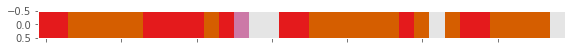

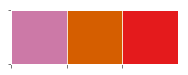

In [415]:
# plot individual covariate track
clrs = ["#CC79A7","#D55E00","#E41A1C"]
map_dict1 =  {'G1': 0.15,'G2': 0.25, 'G3': 0.35}
bounds = np.arange(0.1, len(map_dict1)/10.0 + .2 , 0.1).tolist()
bounds
cmap = colors.ListedColormap(clrs)
norm = colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(10*17/18, .5), facecolor='white', frameon=False)
ax = fig.add_subplot(111)

img = ax.imshow(pd.DataFrame(tumor_grade.map(map_dict1)).T, interpolation='none', 
                origin='upper', aspect='auto',cmap=cmap, norm=norm, label=[1,2,3])
# Gridlines based on minor ticks
_ = ax.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
# hide major tick grid
_ = ax.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.set_xticklabels('')
# plt.colorbar(img)
sns.palplot(sns.color_palette(clrs))

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6]

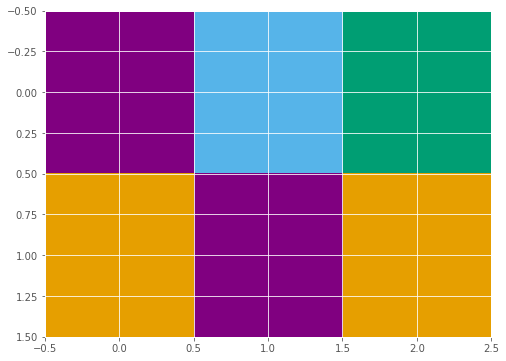

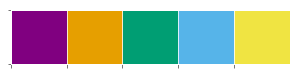

In [353]:
# this is used to test out the list color map
bounds = np.arange(0.1, len(map_dict1)/10.0 + .2 , 0.1).tolist()
bounds
cmap = colors.ListedColormap(clrs)
norm = colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(8, 6), facecolor='white', frameon=False)
ax = fig.add_subplot(111)
dftmp = pd.DataFrame([[0.01, 0.45, 0.35], [0.25, 0.15, 0.25]])
img = ax.imshow(dftmp, interpolation='none', origin='upper', aspect='auto',cmap=cmap, norm=norm)
sns.palplot(sns.color_palette(clrs))

In [ ]:
den_col_labels = membership
num_pats_per_cluster_list = [4, 13, 18]

In [ ]:
def membership(den_col_labels, num_pats_per_cluster_list):
    # example 3 clusters: [4, 13, 18]
    clusters = []
    for k, mem in enumerate(num_pats_per_cluster_list):
        tmp = [k+1 for a in range(mem)]
        clusters+=tmp
    print(clusters)

    df_membership = pd.DataFrame({'patient':den_col_labels, 'cluster':cluster})
    wkdir = '/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_18'
    df_membership.to_csv('{}H3K27ac_cluster_membership.txt'.format(wkdir), index=False, sep='\t')

In [ ]:
membership(den_col_labels, num_pats_per_cluster_list)

# below outdated

In [19]:
f2 = '/projects/da_workspace/software/ChromHMM/Cervical/OUTPUT_18/HTMCP-03-06-02001_18_segments.bed.sorted.intersected'
df2 = pd.read_csv(f2, sep='\t', header=None)
df2.shape

(15478375, 7)

In [17]:
df2.head()

,ix,states,states_number
0,1_0_199_E13_13,E13,13
1,1_200_399_E13_13,E13,13
2,1_400_599_E13_13,E13,13
3,1_600_799_E13_13,E13,13
4,1_800_999_E13_13,E13,13


In [21]:
df2 = df2.astype(str)
df2['ix'] = df2.apply(lambda x: '_'.join(x[:3]), axis=1)
df2.head(2)
df2 = df2[['ix',6]]
df2.columns = ['ix','states' ]
df2['states_number'] = df2.states.str.replace('E', '')
df2.head(2)

,0,1,2,3,4,5,6,ix
0,1,0,199,1,0,9800,E13,1_0_199
1,1,200,399,1,0,9800,E13,1_200_399


,ix,states,states_number
0,1_0_199,E13,13
1,1_200_399,E13,13


In [ ]:
%time df3 = df2.pivot(index='ix', columns='states', values='states_number').fillna(0)
df3.head()

In [13]:
# df2 = df2.astype(str)

In [ ]:
df2.head(2)

In [213]:
# df2['ix'] = df2.apply(lambda x: '_'.join(x[:3]), axis=1)
# df2 = df2[['ix',6]]
# df2.columns = ['ix','states' ]
# df2['states_number'] = df2.states.str.replace('E', '')
# df2.head(2)

In [ ]:
df2.head(2)

In [3]:
df2 = df2[['ix',6]]
df2.columns = ['ix','states' ]
df2['states_number'] = df2.states.str.replace('E', '')
df2.head(2)

states  pa
0 1   2             
1 0   199    E13   1
  200 399    E13   1

In [ ]:
df2 = df2.head(10)

%time df3 = df2.pivot(index=df2.index, columns='states', values='pa').fillna(0)

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(15478375, 4)

3  4     5    6
0 1   2                   
1 0   199  1  0  9800  E13
  200 399  1  0  9800  E13
  400 599  1  0  9800  E13
  600 799  1  0  9800  E13
  800 999  1  0  9800  E13

states  pa
0 1   2             
1 0   199    E13   1
  200 399    E13   1